# Free Response Emotion Labels: Analysis Notebook

## Combination KH&EW code

_________________

### Housekeeping

In [2]:
import numpy as np
from scipy import stats as ssp
import scipy as sp
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina' 

In [5]:
print(np.__version__) #1.24.4
print(pd.__version__) #2.0.3

1.24.4
2.0.3


In [3]:
from collections import Counter

In [4]:
#loading Roberta Vectors
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [7]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

## Getting the Data

In [5]:
df1 = pd.read_csv("../Input/Study1_PromptData_Cleaned.csv")

In [6]:
df1.head()

,PPID,Final50,Day,Time,Valence,Arousal,Word1,Intensity1,Word2,Intensity2,Word3,Intensity3,Word4,Intensity4,Phrase
0,2,1,1,10:09,20,2,excited,2.0,NaN,NaN,NaN,NaN,NaN,NaN,excited
1,2,1,1,10:33,32,4,busy,3.0,NaN,NaN,NaN,NaN,NaN,NaN,busy
2,2,1,1,11:24,35,28,happy,3.0,NaN,NaN,NaN,NaN,NaN,NaN,happy
3,2,1,1,11:39,44,47,excited,4.0,anxious,4.0,NaN,NaN,NaN,NaN,excited anxious
4,2,1,1,11:49,-27,38,frustrated,4.0,stressed,4.0,annoyed,4.0,NaN,NaN,frustrated stressed annoyed


In [7]:
df2 = pd.read_csv("../Input/Study2_PromptData_Cleaned.csv")

In [8]:
df2.head()

,ParticipantID,Notification Time,Session Name,WeekNumber,NotificationNumber,Completed Session,Session Instance,Session Length,Valence,Intensity,Arousal,Emotion
0,28774-003586,08:28.0,Survey,1.0,1,1,1,01:29.8,4,0,3,neutral
1,28774-003586,50:41.0,Survey,1.0,2,1,2,01:24.4,5,1,3,just
2,28774-003586,35:25.0,Survey,1.0,3,1,3,00:59.4,7,3,7,engaged
3,28774-003586,25:09.0,Survey,1.0,4,1,4,01:18.2,5,1,3,serine
4,28774-003586,33:34.0,Survey,1.0,6,1,5,00:58.4,6,2,5,Engaged


In [16]:
df1['Phrase'] = df1['Phrase'].str.strip()
df2['Emotion'] = df2['Emotion'].str.strip()

In [23]:
print(df1['Phrase'].isna().sum())
print(df2['Emotion'].isna().sum())

0
0


In [98]:
df1['Phrase'] = df1['Phrase'].str.replace('\r', ' ').str.replace('\n', ' ').replace('\s+', ' ', regex=True)
df2['Emotion'] = df2['Emotion'].str.replace('\r', ' ').str.replace('\n', ' ').replace('\s+', ' ', regex=True)

In [99]:
df1_unique_phrases = df1['Phrase'].unique()

In [100]:
df2_unique_phrases = df2['Emotion'].unique()

In [101]:
len(df1_unique_phrases)

1717

In [102]:
len(df2_unique_phrases)

7553

### Part 1: NN Inference

In [103]:
#get the roberta positions for the unique words
roberta1 = model.encode(df1_unique_phrases,show_progress_bar=True)
roberta_dict1 = dict(zip(df1_unique_phrases, roberta1))

Batches:   0%|          | 0/54 [00:00<?, ?it/s]

In [104]:
roberta2 = model.encode(df2_unique_phrases,show_progress_bar=True)
roberta_dict2 = dict(zip(df2_unique_phrases, roberta2))

Batches:   0%|          | 0/237 [00:00<?, ?it/s]

In [108]:
Property = pd.read_table("../../NRC_Data/NRC-VAD-Lexicon/NRC-VAD-Lexicon.txt",header=None)

In [109]:
Property.columns = ['Word','Valence','Arousal','Dominance']

In [110]:
Property[['Valence','Arousal','Dominance']].corr()

,Valence,Arousal,Dominance
Valence,1.000000,-0.268083,0.487737
Arousal,-0.268083,1.000000,0.302340
Dominance,0.487737,0.302340,1.000000


In [130]:
WORDPROP = "Valence"

In [116]:
#Valence= {Shit, Nightmare, Toxic' to {Love, Very positive, Enjoyable}
#Arousal = {Siesta, Napping, Mellow} to {Homicide, Exorcism, Abduction"
#Dominance = {Weak, Frail, Empty} to {Success, Leadership, Powerful}

In [117]:
Property

,Word,Valence,Arousal,Dominance
0,aaaaaaah,0.479,0.606,0.291
1,aaaah,0.520,0.636,0.282
2,aardvark,0.427,0.490,0.437
3,aback,0.385,0.407,0.288
4,abacus,0.510,0.276,0.485
...,...,...,...,...
19966,zoo,0.760,0.520,0.580
19967,zoological,0.667,0.458,0.492
19968,zoology,0.568,0.347,0.509
19969,zoom,0.490,0.520,0.462


In [118]:
Property = Property[['Word',WORDPROP]]

In [119]:
 Property[pd.isnull(Property['Word'])]

,Word,Valence
11915,NaN,0.253


In [120]:
Property = Property[~pd.isnull(Property['Word'])]

In [121]:
len(Property)

19970

In [122]:
WordPropertyRoberta = model.encode(Property['Word'].values.tolist(),
                                   show_progress_bar=True)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [123]:
roberta_dict_property = dict(zip(Property['Word'].values.tolist(), WordPropertyRoberta))

In [124]:
roberta_dict_property = dict(zip(Property['Word'].values.tolist(), WordPropertyRoberta))
Property['robertaVec'] = Property['Word'].apply(lambda x: roberta_dict_property[x])

In [125]:
def GetProperty(word,RatedData,WordProp,topN,weightbydistance=False,TestInference = False,
               AlreadyEncoded=False):
    """
    Performs nearest neighbors inference to geta at word properties. 
    
    >>>> Currently hardcoded for Property <<<<<
    
    INPUT DATATYPES:
        word: String
        Property: 3 Column Dataframe consisting of *words*,*Property ratings*, and *roberta vectors* 
        topN: Int / number of nearest neighbors to use
        weightbydistance: Boolean
        TestInference: Boolean
        #TODO: AlreadEncoded: Boolean, controls whether this program gets a word or an already enocded word vector
        
    
    NOTES:
        - This algorithim uses COSINE Distance
        
        - If TestInference == False, the function performs a lookup. If the lookup fails, it does NN inference.
            Use this option if a) speed is a concern or b) you want the exact rating if the word was rated.
        

        - If TestInferences == True, the function skips the lookup part and does NN inference for the word.
            If the word is in the word-ratings, it removes the word from the NN search,
            and then performs NN inference.
   
        - Potential ways to extend this: 
            * Generalize beyond hard-coded Property or hard-coded valence
            * Use more than one vector space
            * Use an empirically determined radius cutoff instead of N nearest neighbors
            
            * Use a small neural network to dynamically determine the weights once the topN positions
                are selected.
        
            * Somehow incorporate the inverse of the furthest away neighbors?
            
        - Potential ways to improve performance:
            * Ball-tree index for discarding things that are near other points too far away to be
                nearest neighbors
            * Boost ram
            * Apply this function in parallel. 
   
    """
    RatedData = RatedData.copy(deep=True)
    word = word.lower() #
    
    # If the word is known...
    if word in set(RatedData['Word']):
        
         #and if we want to just perform the lookup...
        if not TestInference:
            print("LOOKUP")
            #...look up the rated value in the dataframe
            c = RatedData[RatedData['Word']==word][WordProp].values[0]
            return c
        
        
        #otherwise...
        else:
            #...remove the word from the dataframe and proceed
            RatedData = RatedData[RatedData['Word']!= word]
   
    #print(len(RatedData))
    #get the position for the target word in question:
    TargetVector = model.encode(word)# / mu[0][0:768]
    #TV = np.dot(TargetVector, W)
    TargetDistances_NRC  = sp.spatial.distance.cdist(TargetVector.reshape(1,-1),
                                                     np.stack(RatedData['robertaVec'].values),
                                                     metric='cosine'
                                                    )
                            #^^ sp...cdist() quickly gets the cosine distance between all of 
                            # the points in the first input and all of the points in the 
                            # second input. In this case, the first input is a single point.
                
                            ## np.stack() re-arranges the values of the robertaVec vectors to be in a format
                            ## that plays nicely with sp.spatial.distance.cdist()
        
    
    #Now, transfer the distances back to the Property dataframe and sort
    RatedData.loc[:,'TargetDistances'] = TargetDistances_NRC[0]
    Sorted_Data = RatedData.sort_values('TargetDistances') #sorts from small to big by default.
    
    #We are now in a position where the top N Sorted_Property entries are the nearest neighbors.

    if weightbydistance:
        #STEPS:
        #A: Scale the distances by taking ratio of each to the max possible distance
        #B: Subtract each scaled distance from 1 to use as weights: closer distances are now closer to 1
        #C: Rescale the weights to be percentages
        #D: Take a weighted average.
     
        #be sure to use N+1 nearest neighbors, as the furthest away neighbor gets shrunk to 0.
        
        # ------------
        
        #Get the Nearest N+1 words and corresponding distances
        #print(Sorted_Property.head())
        Top_NRC = Sorted_Data[['Word',WordProp,'TargetDistances']].iloc[0:topN+1]
        #If the word isn't taken out of the dataset, this should be change to be 0 to topN
        
        #Divide all of the distances by the furthest away distance,
        #and,
        #invert the scaled distances so that the closest ones get the biggest weight:
        Top_NRC.loc[:,'ScaledDistances'] = 1 - Top_NRC['TargetDistances']/Top_NRC['TargetDistances'].max()
        
        #convert the weights to percentages (first step in computing a weighted average)
        Top_NRC.loc[:,'SDWeights'] = Top_NRC['ScaledDistances']/Top_NRC['ScaledDistances'].sum()

        #the next two lines complete the weighted average calculation
        Weighted=  Top_NRC['SDWeights'] * Top_NRC[WordProp]
       
        NRC_Infered_Valence = Weighted.sum()
        return NRC_Infered_Valence
    else:
        Top_NRC = Sorted_Data[['Word',WordProp,'TargetDistances']].head(topN)
        return Top_NRC['Valence'].sum()/len(Top_NRC)


In [74]:
sample = Property.sample(500) #for testing the NN inference accuracy

In [75]:
#sample_infer = [GetProperty(x,Property,'Valence',10,True,True) for x in sample['Word'].values.tolist()]

In [76]:
#sp.stats.pearsonr(sample['Valence'],sample_infer)

In [77]:
BetterSampleInfer = [GetProperty('I feel '+x,Property,'Valence',10,True,True) for x in sample['Word'].values.tolist()]

In [78]:
sp.stats.pearsonr(sample['Valence'],BetterSampleInfer) # the value below changes slightly depending on the sample, from ~.88 to ~.91

PearsonRResult(statistic=0.8988209754950441, pvalue=1.6191253426152356e-180)

In [82]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, "Actual vs. Inferred Valences, 500 random words, 'multi-qa-mpnet-base-dot-v1'")

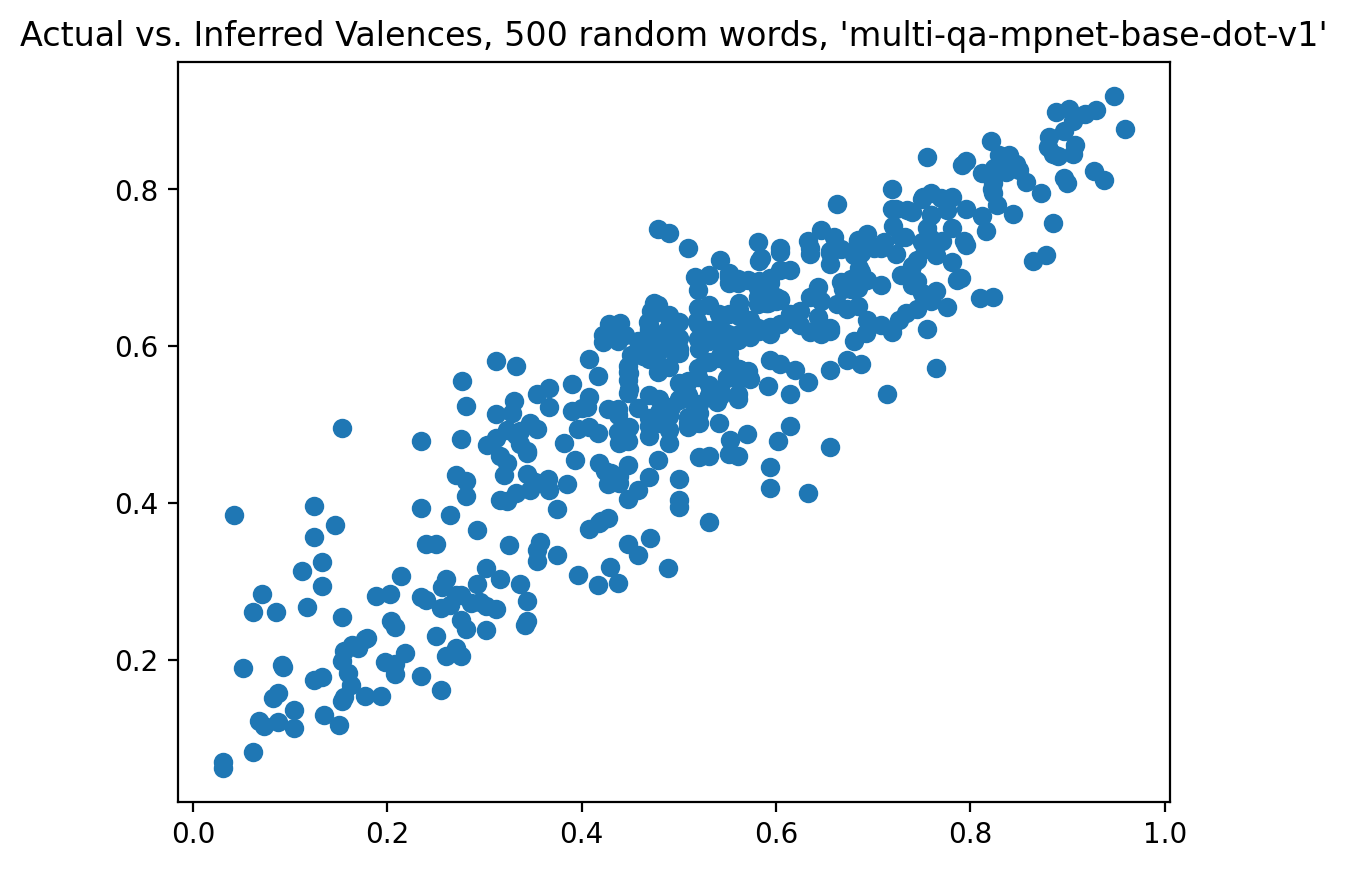

In [83]:
plt.scatter(sample['Valence'],BetterSampleInfer)
plt.title("Actual vs. Inferred Valences, 500 random words, 'multi-qa-mpnet-base-dot-v1'")

## Actual inference

In [84]:
df1

,PPID,Final50,Day,Time,Valence,Arousal,Word1,Intensity1,Word2,Intensity2,Word3,Intensity3,Word4,Intensity4,Phrase
0,2,1,1,10:09,20,2,excited,2.0,NaN,NaN,NaN,NaN,NaN,NaN,excited
1,2,1,1,10:33,32,4,busy,3.0,NaN,NaN,NaN,NaN,NaN,NaN,busy
2,2,1,1,11:24,35,28,happy,3.0,NaN,NaN,NaN,NaN,NaN,NaN,happy
3,2,1,1,11:39,44,47,excited,4.0,anxious,4.0,NaN,NaN,NaN,NaN,excited anxious
4,2,1,1,11:49,-27,38,frustrated,4.0,stressed,4.0,annoyed,4.0,NaN,NaN,frustrated stressed annoyed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,68,1,14,11:05,18,-30,happy,4.0,NaN,NaN,NaN,NaN,NaN,NaN,happy
5568,68,1,14,11:15,18,21,happy,4.0,NaN,NaN,NaN,NaN,NaN,NaN,happy
5569,68,1,14,12:08,24,-28,happy,4.0,NaN,NaN,NaN,NaN,NaN,NaN,happy
5570,68,1,14,12:16,20,-31,happy,4.0,NaN,NaN,NaN,NaN,NaN,NaN,happy


In [126]:
df1['robertaVec'] = df1['Phrase'].apply(lambda x: roberta_dict1[x])

In [127]:
df2['robertaVec'] = df2['Emotion'].apply(lambda x: roberta_dict2[x])

In [131]:
df1_valence_values = [GetProperty('I feel '+x,Property,'Valence',10,True,False) for x in df1_unique_phrases] #this could probably be parallelized...

In [132]:
df1_valence_dict = dict(zip(df1_unique_phrases, df1_valence_values))

In [133]:
df1['InferredValence'] = df1['Phrase'].apply(lambda x: df1_valence_dict[x])

In [137]:
df2['robertaVec'] = df2['Emotion'].apply(lambda x: roberta_dict2[x])

In [139]:
df2_valence_values = [GetProperty('I feel '+x,Property,'Valence',10,True,False) for x in df2_unique_phrases]

In [140]:
df2_vv = dict(zip(df2_unique_phrases,df2_valence_values))

In [142]:
df2['InferredValence'] = df2['Emotion'].apply(lambda x: df2_vv[x])

#### Saving

In [167]:
df1.drop('robertaVec',axis=1).to_csv("../Output/Study1_PromptData_Cleaned_WithInferredValence.csv")
#Only saving a subset of columns, but with enough info to be joined with the main df if needed

In [168]:
df2.drop('robertaVec',axis=1).to_csv("../Output/Study2_PromptData_Cleaned_WithInferredValence.csv")

In [ ]:
df2[word_columns].apply(lambda x: GetValences(x),axis=1)

In [ ]:
df2[word_columns].apply(lambda x: np.mean(GetValences(x)),axis=1)

In [154]:
RelevantSubjects = df1['PPID'].unique().tolist()

In [155]:
RelevantSubjects = RelevantSubjects[0:43] + RelevantSubjects[44:48] + RelevantSubjects[49:]

In [156]:
assert len(RelevantSubjects) == 50

In [158]:
ProcessedData = pd.DataFrame([GetPerSubjectData(x,df1) for x in RelevantSubjects])

ProcessedData.columns = ["SubjectID",
                        "CountWords_All",
                        "CountWords_Uniq",
                        "MeanWordsPerPrompt",
                        "NumPositiveWords_All",
                        "NumNegativeWords_All",
                        "NumPositiveWords_Uniq",
                        "NumNegativeWords_Uniq",
                        "ProportionUniquePositive",
                        "ProportionUniqueNegative",
                         "MeanInferredValenceOverAllPrompts",
                         "MeanRatedValence"]

NameError: name 'GetAllWords' is not defined

In [ ]:
ProcessedData = ProcessedData.set_index('SubjectID')

In [ ]:
QuestionnaireData = pd.read_csv("ARI_QuestionnaireData.csv")
#Strategy is to do the small data transforms in the QuestionnaireData dataframe,
#join that to the ProcessedData using the "ID" as the key/index,
#then get the correlations / the correlations we are interested in.

In [ ]:
QuestionnaireData = QuestionnaireData.set_index("ID")

In [ ]:
QuestionnaireData['GAD7'] = (QuestionnaireData['GAD71.Total'] + QuestionnaireData['GAD72.Total'])/2
QuestionnaireData['PHQ8'] = (QuestionnaireData['PHQ81.Total'] + QuestionnaireData['PHQ82.Total'])/2
QuestionnaireData['MentalHealth'] = (ssp.zscore(QuestionnaireData['GAD7'],ddof=1) +ssp.zscore(QuestionnaireData['PHQ8'],ddof=1))/2

#for the zscore ddof param, see:
#https://stackoverflow.com/questions/54453483/zscore-in-python-and-matlab-have-different-result

In [ ]:
FinalData = pd.merge(ProcessedData,QuestionnaireData,left_index=True,right_index=True)
#This merge works *because* we already set the index of each dataframe. If one doesn't do that,
#one can specify column names

In [ ]:
FinalData.head()

In [ ]:
ToCorrelate = FinalData[[
         "MeanWordsPerPrompt",
          'ProportionUniquePositive',
          'ProportionUniqueNegative',
          'MeanInferredValenceOverAllPrompts',
          'MeanRatedValence',
          'MentalHealth',
          'Neuroticism',
          'Extroversion',
          'Openness',
          'Agreeableness',
          'Conscientiousness'
         ]]

In [ ]:
ToCorrelate.corr()
#defaults to pearson. (Press shift+tab with your cursor between the parens of a function to see defaults etc.)

In [ ]:
#for a quick visual guide to p-values...
#shamelessly copy+pasted from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
#woo hoo for open source!
from scipy.stats import pearsonr
import numpy as np
rho = ToCorrelate.corr()
pval = ToCorrelate.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
final  = rho.round(2).astype(str) + p

In [ ]:
pd.DataFrame(np.triu(final),columns = final.columns,index=final.columns) #triu = upper triangle
#note that these are rounded to two decimal places:

In [ ]:
ToCorrelate

In [ ]:
ssp.pearsonr(ToCorrelate['MeanInferredValenceOverAllPrompts'],ToCorrelate['MeanRatedValence'])
#results are (correlation coefficent, p-value)
#(0.6462439117729213, 1.6272690534557846e-06), compare to .55 x
#(0.640170976825035, 5.554748481181413e-07), compare to .55 x

In [ ]:
ssp.pearsonr(ToCorrelate['MentalHealth'],ToCorrelate['ProportionUniqueNegative'])
#
#(-0.46806483275014804, 0.00118535312553292),compare to -.36 x

In [ ]:
ssp.pearsonr(ToCorrelate['Openness'],ToCorrelate['MeanWordsPerPrompt'])
#
#(0.25374068832780905, 0.09258887132127319),compare to .29 ✓

In [ ]:
ssp.pearsonr(ToCorrelate['Neuroticism'],ToCorrelate['ProportionUniquePositive'])
#
#(0.3963252737816053, 0.007035283015489286),compare to .32 x

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
checkplot = plt.subplot(111)
checkplot.scatter(ToCorrelate['MeanInferredValenceOverAllPrompts'],ToCorrelate["MeanRatedValence"])
checkplot.set_xlim([0, 1])
checkplot.set_ylim([-10, 40])
#The data at (.2,-8) is missing....

In [ ]:
checkplot = plt.subplot(111)
checkplot.scatter(ToCorrelate["MeanWordsPerPrompt"],ToCorrelate['Openness'])
checkplot.set_xlim([1, 4])
checkplot.set_ylim([0, 180])

In [ ]:
checkplot = plt.subplot(111)
checkplot.scatter(ToCorrelate['ProportionUniquePositive'],ToCorrelate["Neuroticism"],)
checkplot.set_xlim([0,1])
checkplot.set_ylim([0, 180])

In [ ]:
checkplot = plt.subplot(111)
checkplot.scatter(ToCorrelate["ProportionUniqueNegative"],ToCorrelate['MentalHealth'],)
checkplot.set_xlim([0,1])
checkplot.set_ylim([-2, 4])